# *Mutual Interactors* for discovering novel aging-protein associations in *C. elegans*

**Bradley Buchner**

This notebook includes an implementation of *Mutual Interactors*, a network-based machine learning framework developed by Eyuboglu, et. al. for the discovery of phenotypes in molecular networks. For a more detailed description of how the method works, please see their paper: https://pubmed.ncbi.nlm.nih.gov/36540965/

As Eyuboglu, et. al. put it, *Mutual Interactors* works by expanding node-sets in networks. A node set is considered any group of nodes that are all associated with the same concept, and to expand a node set is to predict what other nodes might be associated with the same concept. For example, in a protein-protein interaction network, the set of proteins known to be associated with Lymphoma make up a node set. By expanding this node set, we are predicting which other proteins might also be associated with Lymphoma (https://github.com/seyuboglu/milieu/tree/master).

*Mutual Interactors* expands node sets by relying on what Eyuboglu, et. al. call the *Mutual Interactor* principle. It states that, on average, two molecules that interact directly with one another will have less in common than two molecules that share many mutual interactors. Eyuboglu, et. al. find this principle to hold true empirically, concluding that most molecules associated with similar phenotypes do not interact directly in molecular networks.

Motivated by these findings, Eyuboglu, et. al. developed *Mutual Interactors*, a machine learning framework that can predict a molecule’s phenotype based on the mutual interactors it shares with other molecules. *Mutual Interactors* requires only two inputs to learn phenotype-protein associations: (1) The full interactome of the organism, represented as a graph with nodes (genes/proteins) and edges (interactions), and (2) sets of nodes associated with various phenotypes, including a node set for the phenotype that you are looking to expand. Using these inputs, *Mutual Interactors* scores candidate phenotype-protein associations by evaluating the mutual interactors shared between the candidate protein and other proteins already known to be associated with a given phenotype. Specifically, *Mutual Interactors* learns a weight for every protein in the interactome, which can be thought of as each protein's significance as a mutual interactor. This captures the fact that not all mutual interactors are the same, allowing *Mutual Interactors* to learn which ones carry real phenotypic signal.

*Mutual Interactors* is trained via a “meta‐learning” or self‐supervised scheme. At each epoch, 10% of each phenotype's node set is randomly held out, and the remaining 90% is used by the model to recover or "find" the held-out 10% that is hidden among the rest of the nodes in the network. This simulates the real discovery task: only a subset of true positives is known, and the rest must be recovered. More concretely, *Mutual Interactors* scores each candidate protein by aggregating the weights of the mutual interactors it shares with phenotype-associated proteins, which, as previously mentioned, are learned by the model. Finally, learned scale (a) and bias (b) parameters convert the aggregated, weighted mutual interactor score into an activation, which is then passed through a sigmoid to yield a probability. Because each phenotype is randomly split in a new 90/10 fashion every epoch, the network sees many different partial‐observations of each pathway. Over time, weights converge to reflect how informative each protein is as a mutual interactor across all training phenotypes.

In short, *Mutual Interactors* learns which intermediate proteins consistently show up between partial inputs and held‐out positives. During training, it repeatedly practices reconstructing the missing 10% of each node set, refining its interactor weights so that, given any new subset of known members, it can score candidate proteins by the mutual neighbors they share.

In this notebook, *Mutual Interactors* is used to predict protein associations with the biological process of aging in the roundworm *C. elegans*. The models inputs include (1) the organism's full genetic and molecular interaction network as a graph with 11,513 nodes (genes/proteins) and 84,667 edges (interactions), and (2) a collection of 694 different biological processes in *C. elegans* and the genes known to be associated with them, including the process of aging (a.k.a. the GO term "determination of adult lifespan"). Using these inputs, *Mutual Interactors* is able to infer phenotype-protein associations at a level that is significantly better than a randomized model. Specifically, the model is able to recover held-out proteins and reconstruct node sets at a high rate, scoring 30.4% of held-out positives in the top 25 of predictions for phenotypes that the model did not see during training (recall-at-25 = 30.4). These results show that *Mutual Interactors* is capable of producing a prioritized, experimentally actionable list of new phenotype–protein associations.


Note: Following Eyuboglu, et. al., the name "Milieu" is used a shorthand for Mutual Interactors in the code below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import torch
import pickle

from milieu.data.network import Network
from milieu.milieu import MilieuDatasetWorm, MilieuWorm
from milieu.data.associations import load_biological_processes

In [2]:
print("Old wd:", os.getcwd())
parent_dir = os.path.dirname(os.getcwd())
os.chdir(parent_dir)

wd = os.getcwd()
print("New wd:", wd)

Old wd: /Users/bradleybuchner/Desktop/Grad School/Research/Aging Project/milieu/notebooks
New wd: /Users/bradleybuchner/Desktop/Grad School/Research/Aging Project/milieu


In [3]:
path_to_worm_data = os.path.join(wd, "data")
path_to_worm_network = os.path.join(path_to_worm_data, "networks/species_6239/wormbase")
path_to_worm_associations = os.path.join(path_to_worm_data, "associations/wormbase")

### Load network and association data

In [4]:
# === Build the network using the adjacency list file path ===
adj_list_path = os.path.join(path_to_worm_network, "worm_network_basic_full_adjacency.txt")
full_network = Network(adj_list_path)
print(full_network.nx)

Graph with 11513 nodes and 84667 edges


In [7]:
# === Load biological process association data ===
associations_file_path = os.path.join(path_to_worm_associations, 'biological_process_associations.csv')
bp_associations = pd.read_csv(associations_file_path)
display(bp_associations.head())

print(f"Number of biological processes: {bp_associations.shape[0]}")

,biological_process_id,biological_process_name,associated_gene_wb_ids,count,splits
0,GO:0000002,mitochondrial genome maintenance,"WBGene00004028,WBGene00011662,WBGene00019800,W...",4,none
1,GO:0000014,single-stranded DNA endodeoxyribonuclease acti...,"WBGene00000787,WBGene00001016,WBGene00003405,W...",4,none
2,GO:0000022,mitotic spindle elongation,"WBGene00002994,WBGene00006381",2,none
3,GO:0000027,ribosomal large subunit assembly,"WBGene00004416,WBGene00007617,WBGene00012692,W...",6,none
4,GO:0000028,ribosomal small subunit assembly,"WBGene00004469,WBGene00004474,WBGene00004483,W...",11,none


Number of biological processes: 4067


In [8]:
# === Subset biological processes with at least 10 associated genes ===
bp_subset = []
for row in bp_associations.itertuples(index=False):
    if not row.count < 10:
        bp_subset.append(row.biological_process_id)

# Print number of retained biological processes and total processes
print(f"Number of biological processes with 10 or more associated genes: {len(bp_subset)}")

Number of biological processes with 10 or more associated genes: 694


### Extract node sets and create training/validation split

In [9]:
# === Split biological processes into training and validation sets ===
# Make training and validation sets from node sets
random.seed(24)
train_prop = 0.8 # Proportion of data to use for training

# Load NodeSet objects (filtered by bp_subset) from the CSV
node_sets = list(load_biological_processes(associations_file_path, biological_process_subset=bp_subset).values())
random.shuffle(node_sets)
split = int(len(node_sets)*train_prop)
train_node_sets = node_sets[:split]
valid_node_sets = node_sets[split:]

# === Create MilieuDatasetWorm objects ===
train_dataset = MilieuDatasetWorm(full_network, node_sets=train_node_sets)
valid_dataset = MilieuDatasetWorm(full_network, node_sets=valid_node_sets)
full_dataset = MilieuDatasetWorm(full_network, node_sets=node_sets)

### Define model parameters

In [10]:
# === Select computation device ===
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
use_pin_memory = (device.type == "cuda") # Use pinned memory only if using a CUDA GPU

# === Define training and model parameters ===
params = {
    "mps": True,
    "device": 2,
    "seed": 24,
    "batch_size": 32,
    "num_workers": 0,
    "num_epochs": 100,
    "early_stopping_patience": 500, # to not use early stopping, set value greater than num_epochs
    "edge_dropout_alpha": 0.5, # edge dropout probability floor

    "optim_class": "Adam",
    "optim_args": {
        "lr": 0.01,
        "weight_decay": 0.0
    },

    "metric_configs": [
        {
            "name": "recall_at_25",
            "fn": "batch_recall_at",
            "args": {"k":25}
        }
    ]
}

### Build and train a MilieuWorm model

In [11]:
milieu_worm = torch.compile(MilieuWorm(full_network, params))

Milieu
Setting parameters...
Building model...
Building optimizer...
Done.


In [12]:
%%capture
train_metrics, valid_metrics, train_losses, valid_losses = milieu_worm.train_model(train_dataset, valid_dataset)

Starting training for 100 epoch(s)
Epoch 1 of 100
avg_val_loss: 1.88124
Epoch 2 of 100
avg_val_loss: 1.68318
Epoch 3 of 100
avg_val_loss: 1.5378
Epoch 4 of 100
avg_val_loss: 1.43535
Epoch 5 of 100
avg_val_loss: 1.37006
Epoch 6 of 100
avg_val_loss: 1.32739
Epoch 7 of 100
avg_val_loss: 1.29582
Epoch 8 of 100
avg_val_loss: 1.28068
Epoch 9 of 100
avg_val_loss: 1.24639
Epoch 10 of 100
avg_val_loss: 1.23305
Epoch 11 of 100
avg_val_loss: 1.22133
Epoch 12 of 100
avg_val_loss: 1.21225
Epoch 13 of 100
avg_val_loss: 1.1931
Epoch 14 of 100
avg_val_loss: 1.21612
Epoch 15 of 100
avg_val_loss: 1.17983
Epoch 16 of 100
avg_val_loss: 1.1681
Epoch 17 of 100
avg_val_loss: 1.14584
Epoch 18 of 100
avg_val_loss: 1.1349
Epoch 19 of 100
avg_val_loss: 1.14563
Epoch 20 of 100
avg_val_loss: 1.14288
Epoch 21 of 100
avg_val_loss: 1.1419
Epoch 22 of 100
avg_val_loss: 1.11144
Epoch 23 of 100
avg_val_loss: 1.1138
Epoch 24 of 100
avg_val_loss: 1.09862
Epoch 25 of 100
avg_val_loss: 1.09075
Epoch 26 of 100
avg_val_loss: 

### Summarize MilieuWorm training

In [13]:
print("\n=== MilieuWorm Training Summary ===")
print(f"\nMin validation loss: {np.min(valid_losses):.3f}\n")
valid_recalls = [epoch["recall_at_25"] for epoch in valid_metrics]
avg_valid_recalls = [np.mean(epoch["recall_at_25"]) for epoch in valid_metrics]
for epoch, metric in enumerate(avg_valid_recalls):
    print(f"Epoch: {epoch+1}\t avg recall-at-25: {metric:.3f}")

print(f"\nMax avg validation recall-at-25: {np.max(avg_valid_recalls):.3f}\n")


=== MilieuWorm Training Summary ===

Min validation loss: 1.005

Epoch: 1	 avg recall-at-25: 0.202
Epoch: 2	 avg recall-at-25: 0.236
Epoch: 3	 avg recall-at-25: 0.216
Epoch: 4	 avg recall-at-25: 0.248
Epoch: 5	 avg recall-at-25: 0.217
Epoch: 6	 avg recall-at-25: 0.224
Epoch: 7	 avg recall-at-25: 0.214
Epoch: 8	 avg recall-at-25: 0.192
Epoch: 9	 avg recall-at-25: 0.212
Epoch: 10	 avg recall-at-25: 0.209
Epoch: 11	 avg recall-at-25: 0.251
Epoch: 12	 avg recall-at-25: 0.230
Epoch: 13	 avg recall-at-25: 0.220
Epoch: 14	 avg recall-at-25: 0.166
Epoch: 15	 avg recall-at-25: 0.208
Epoch: 16	 avg recall-at-25: 0.187
Epoch: 17	 avg recall-at-25: 0.229
Epoch: 18	 avg recall-at-25: 0.228
Epoch: 19	 avg recall-at-25: 0.218
Epoch: 20	 avg recall-at-25: 0.197
Epoch: 21	 avg recall-at-25: 0.204
Epoch: 22	 avg recall-at-25: 0.233
Epoch: 23	 avg recall-at-25: 0.227
Epoch: 24	 avg recall-at-25: 0.262
Epoch: 25	 avg recall-at-25: 0.247
Epoch: 26	 avg recall-at-25: 0.192
Epoch: 27	 avg recall-at-25: 0.26

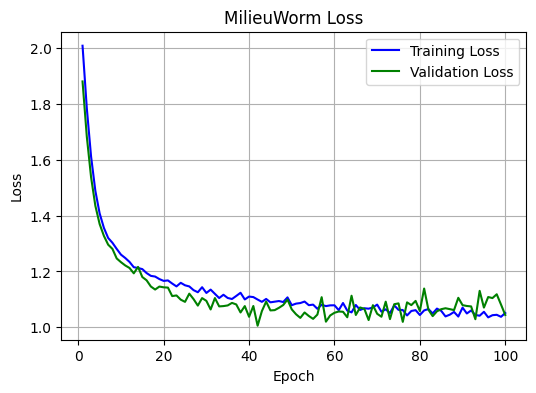

In [14]:
# Plot the training and validation loss
epochs = range(1, len(valid_losses)+1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, valid_losses, 'g', label='Validation Loss')
plt.title('MilieuWorm Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Predict novel associations

In [15]:
aging_associations_str = list(bp_associations[bp_associations["biological_process_name"] == "determination of adult lifespan"]["associated_gene_wb_ids"])[0]
aging_wbid_list = [s.strip() for s in aging_associations_str.split(",")]
print(f"Number of aging-associated genes: {len(aging_wbid_list)}")

Number of aging-associated genes: 262


In [16]:
k = 10
preds = milieu_worm.expand(node_names=aging_wbid_list, top_k=k)

print("=== MilieuWorm Predictions ===\n")
print(f"Top {k} Nodes with Highest Probability of Association with Aging\n")
for i, (name, pred) in enumerate(preds):
    print(f"{i+1}. '{name}' (Prob.: {pred:.7f})")

=== MilieuWorm Predictions ===

Top 10 Nodes with Highest Probability of Association with Aging

1. 'WBGene00003848' (Prob.: 1.0000000)
2. 'WBGene00004799' (Prob.: 1.0000000)
3. 'WBGene00006742' (Prob.: 1.0000000)
4. 'WBGene00004014' (Prob.: 1.0000000)
5. 'WBGene00004015' (Prob.: 1.0000000)
6. 'WBGene00000485' (Prob.: 1.0000000)
7. 'WBGene00012166' (Prob.: 1.0000000)
8. 'WBGene00004727' (Prob.: 1.0000000)
9. 'WBGene00000563' (Prob.: 1.0000000)
10. 'WBGene00009245' (Prob.: 1.0000000)


### Train MilieuWorm using 10-fold cross-validation

In [17]:
def run_cross_validation(full_network, node_sets, params, n_splits=10, random_seed=23):
    """
    Performs k-fold cross-validation for the Milieu model.

    Args:
        full_network: The full gene regulatory network.
        node_sets (list): List of node-sets.
        params (dict): Model and training hyperparameters.
        n_splits (int): Number of folds for cross-validation.
        random_seed (int): Seed for reproducibility.

    Returns:
        cv_summary (dict): Summary metrics for the cross-validation run..
    """
    import logging
    from copy import deepcopy
    from sklearn.model_selection import KFold
    import time

    # ---- START TIMER ----
    start_time = time.perf_counter()
    logging.info(f"Starting {n_splits}-fold cross-validation.")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    train_fold_metrics = []
    val_fold_metrics = []
    train_fold_losses = []
    val_fold_losses = []

    frac_known = params.get("frac_known", 0.9)
    use_mps = params.get("mps", False)
    device = params.get("device", "cpu")
    metric_name = params.get("metric_configs")[0]["name"]
    num_epochs = params.get("num_epochs")

    train_val_split = kf.split(node_sets)

    for fold, (train_idx, val_idx) in enumerate(train_val_split):
        logging.info(f"--- Fold {fold + 1}/{n_splits} ---")

        train_node_sets = [node_sets[i] for i in train_idx]
        valid_node_sets = [node_sets[i] for i in val_idx]

        train_set = MilieuDatasetWorm(full_network, node_sets=train_node_sets,
                                      frac_known=frac_known)

        val_set = MilieuDatasetWorm(full_network, node_sets=valid_node_sets,
                                    frac_known=frac_known)

        model = MilieuWorm(full_network, deepcopy(params), edge_dropout=False)
        if use_mps:
            model.to(device)
        model._build_optimizer()

        train_metrics, val_metrics, train_losses, val_losses = model.train_model(train_set, val_set)
        del model
        torch.mps.empty_cache()

        train_fold_metrics.append(train_metrics)
        val_fold_metrics.append(val_metrics)
        train_fold_losses.append(train_losses)
        val_fold_losses.append(val_losses)

    cv_val_metrics = {}
    for fold, fold_results in enumerate(val_fold_metrics):
        cv_val_metrics[f"fold_{fold + 1}"] = [np.mean(epoch_result.get(metric_name)) for epoch_result in fold_results]

    cv_val_losses = {f"fold_{fold + 1}": fold_results for fold, fold_results in enumerate(val_fold_losses)}

    best_fold_metric_val = []
    for fold, metrics in cv_val_metrics.items():
        best_fold_metric_val.append(np.max(metrics))

    best_fold_loss_val = []
    for fold, losses in cv_val_losses.items():
        best_fold_loss_val.append(np.min(losses))

    avg_val_metrics = []
    for epoch in range(num_epochs):
        epoch_results = [vals[epoch] for fold, vals in enumerate(cv_val_metrics.values())]
        avg_val_metrics.append(np.mean(epoch_results))

    avg_val_losses = []
    for epoch in range(num_epochs):
        epoch_results = [vals[epoch] for fold, vals in enumerate(cv_val_losses.values())]
        avg_val_losses.append(np.mean(epoch_results))

    # ---- STOP TIMER ----
    elapsed = time.perf_counter() - start_time
    mins, secs = divmod(elapsed, 60)
    elapsed_str = f"{int(mins)} minute{'s' if mins!=1 else ''} and {secs:.2f} seconds"
    logging.info(f"Cross-validation completed in {elapsed_str}.")

    cv_summary = {
        "elapsed_time_sec": elapsed,
        "elapsed_time_str": elapsed_str,
        "best_metric_folds_val_cv": best_fold_metric_val,
        "best_loss_folds_val_cv": best_fold_loss_val,
        "val_loss_epochs_cv": avg_val_losses,
        "val_metric_epochs_cv": avg_val_metrics,
        "avg_best_metric_val": np.mean(best_fold_metric_val),
        "avg_best_loss_val": np.mean(best_fold_loss_val)
    }

    return cv_summary

In [ ]:
# Run cross-validation
# %%capture
cv_result_summary = run_cross_validation(full_network, node_sets, params, n_splits=10, random_seed=23)

In [ ]:
# Save to pickle (if necessary)
with open(os.path.join(path_to_worm_network, "milieu_cv_results.pkl"), "wb") as f:
    pickle.dump(cv_result_summary, f)

In [18]:
# Load CV results if its has already been run and results have been saved
with open(os.path.join(path_to_worm_network, "milieu_cv_results.pkl"), "rb") as f:
    cv_result_summary = pickle.load(f)

In [28]:
print("=== 10-fold CV Results ===\n")
# print(f"10-fold CV best validation recall-at-25: {cv_result_summary.get('best_metric_folds_val_cv_n')}\n")
print(f"Avg best validation recall-at-25: {cv_result_summary.get('avg_best_metric_val_n'):.3f}")
# print(f"10-fold CV best validation loss: {cv_result_summary.get('best_loss_folds_val_cv_n')}\n")
print(f"Avg best validation loss: {cv_result_summary.get('avg_best_loss_val_n'):.3f}")

=== 10-fold CV Results ===

Avg best validation recall-at-25: 0.304
Avg best validation loss: 1.014



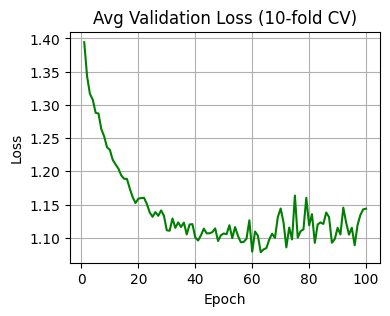

In [29]:
# Plot the training and validation loss
val_losses_n = cv_result_summary['val_loss_epochs_cv_n']
epochs = range(1, len(val_losses_n)+1)

plt.figure(figsize=(4, 3))
plt.plot(epochs, val_losses_n, 'g')
plt.title('Avg Validation Loss (10-fold CV)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Test the significance of 10-fold CV validation recall-at-25

In [30]:
# Load a distribution of null recall-at-25 values generated from a randomized model
val_metric_null_dist = np.load(os.path.join(path_to_worm_network, "val_metric_null_dist.npy"))

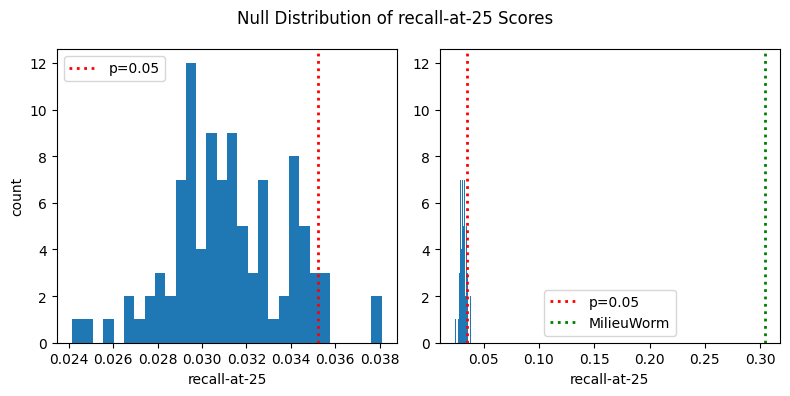


=== Significance of 10-fold CV Results: ===

recall-at-25: 0.30396	 p-value: 0.0099 ***


In [39]:
# Plot the null distribution of recall-at-25 scores
p95 = np.percentile(val_metric_null_dist, 95)

# Compute p-values
actual_n = cv_result_summary['avg_best_metric_val_n']

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 1 row, 2 columns
axes[0].hist(val_metric_null_dist, bins=30)
axes[0].axvline(p95,
            color='red',
            linestyle=':',
            linewidth=2,
            label=f'p=0.05')

axes[1].hist(val_metric_null_dist, bins=30)
axes[1].axvline(p95,
            color='red',
            linestyle=':',
            linewidth=2,
            label=f'p=0.05')

axes[1].axvline(actual_n,
            color='g',
            linestyle=':',
            linewidth=2,
            label=f'MilieuWorm')

axes[0].set_xlabel("recall-at-25")
axes[0].set_ylabel("count")

axes[1].set_xlabel("recall-at-25")

axes[0].legend()
axes[1].legend()
fig.suptitle("Null Distribution of recall-at-25 Scores")
plt.tight_layout()
plt.show()

p_val_n = (np.sum(np.array(val_metric_null_dist) >= actual_n) + 1) / (len(val_metric_null_dist) + 1)

print("\n=== Significance of 10-fold CV Results: ===")
print(f"\nrecall-at-25: {actual_n:.5f}\t p-value: {p_val_n:.4f} ***")

### Build and train MilieuWorm on all node sets (training + validation)

In [40]:
# Train on all nodes sets (training + validation)
from copy import deepcopy
params_full = deepcopy(params)
params_full["num_epochs"] = 50 # Validation loss seems to bottom out around epoch 50
milieu_worm_full = MilieuWorm(full_network, params_full)
train_metrics_full, train_losses_full = milieu_worm_full.train_model(full_dataset)

Milieu
Setting parameters...
Building model...
Building optimizer...
Done.
Starting training for 50 epoch(s)
Epoch 1 of 50
Epoch 2 of 50
Epoch 3 of 50
Epoch 4 of 50
Epoch 5 of 50
Epoch 6 of 50
Epoch 7 of 50
Epoch 8 of 50
Epoch 9 of 50
Epoch 10 of 50
Epoch 11 of 50
Epoch 12 of 50
Epoch 13 of 50
Epoch 14 of 50
Epoch 15 of 50
Epoch 16 of 50
Epoch 17 of 50
Epoch 18 of 50
Epoch 19 of 50
Epoch 20 of 50
Epoch 21 of 50
Epoch 22 of 50
Epoch 23 of 50
Epoch 24 of 50
Epoch 25 of 50
Epoch 26 of 50
Epoch 27 of 50
Epoch 28 of 50
Epoch 29 of 50
Epoch 30 of 50
Epoch 31 of 50
Epoch 32 of 50
Epoch 33 of 50
Epoch 34 of 50
Epoch 35 of 50
Epoch 36 of 50
Epoch 37 of 50
Epoch 38 of 50
Epoch 39 of 50
Epoch 40 of 50
Epoch 41 of 50
Epoch 42 of 50
Epoch 43 of 50
Epoch 44 of 50
Epoch 45 of 50
Epoch 46 of 50
Epoch 47 of 50
Epoch 48 of 50
Epoch 49 of 50
Epoch 50 of 50


### Predict novel associations with the final model

In [41]:
k = 10
preds = milieu_worm_full.expand(node_names=aging_wbid_list, top_k=k)

print("=== MilieuWorm Predictions ===\n")
print(f"Top {k} Nodes with Highest Probability of Association with Aging\n")
for i, (name, pred) in enumerate(preds):
    print(f"{i+1}. '{name}' (Prob.: {pred:.7f})")


=== MilieuWorm Predictions ===

Top 10 Nodes with Highest Probability of Association with Aging

1. 'WBGene00004015' (Prob.: 1.0000000)
2. 'WBGene00305568' (Prob.: 1.0000000)
3. 'WBGene00006526' (Prob.: 1.0000000)
4. 'WBGene00004799' (Prob.: 1.0000000)
5. 'WBGene00006070' (Prob.: 1.0000000)
6. 'WBGene00004014' (Prob.: 1.0000000)
7. 'WBGene00002162' (Prob.: 1.0000000)
8. 'WBGene00004930' (Prob.: 1.0000000)
9. 'WBGene00004932' (Prob.: 0.9999999)
10. 'WBGene00004758' (Prob.: 0.9999999)


In [ ]:
# %%capture
wd = os.getcwd()
path = os.path.join(wd, 'notebooks/milieu_worm_walkthrough.ipynb')
!jupyter nbconvert --to HTML "{path}"